In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jax.scipy.optimize import minimize 
from LombScargle import periodogram, psd
from hypothesis_testing.bayes_factor import logB

from simulations.util import  *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


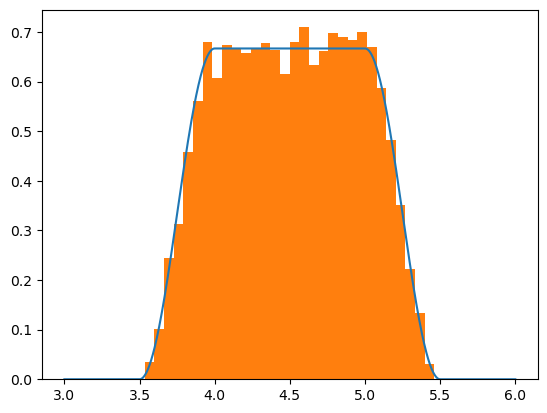

In [12]:



p, g = uniform_with_smooth_edge(4., 5., 0.5)
key = jax.random.PRNGKey(0)


X = jax.vmap(g)(jax.random.split(key, 10000))
x = jnp.linspace(3, 6, 1000)

plt.plot(x, jnp.exp(-p(x)))
plt.hist(np.array(X), bins = 30, density= True)
plt.show()

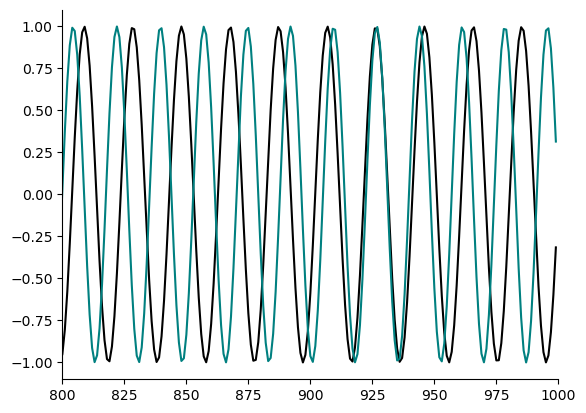

In [12]:
from simulations.synthetic import lee3_freq, time_sampling


get_time = time_sampling['equal'][1]
time, freq = get_time()
freqnull= drifting_freq(time, freq)

s = periodogram.lomb_scargle(time, freq[50])[0]
s3 = periodogram.lomb_scargle(time, freqnull[50])[0]

#plt.plot(time, s, color = 'black')
plt.plot(time, s3)
plt.xlim(800, 1000)
plt.show()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


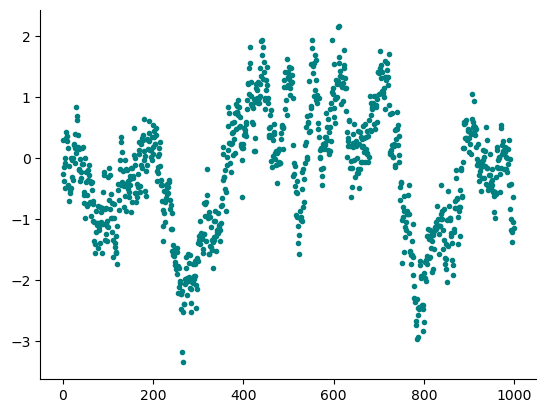

In [1]:
from simulations.synthetic import *

key = jax.random.PRNGKey(42)

get_time = time_sampling['equal'][1]
get_data = noise['correlated'][1]

time, freq = get_time()

data = get_data(key, time)
# score, _ = jax.vmap(periodogram.func(time, data))(freq)
# return jnp.max(score)


plt.plot(time, data, '.')
plt.show()

In [3]:
known = pd.read_csv('quasars/known.csv')
data= pd.read_csv('data/data.csv')
data= data.sort_values('myid')
period = np.array(data['period'])
period0 = np.array(known['period'])


print(period[13], period0[13])

654.4673 309.7


In [2]:
# setup
key = jax.random.PRNGKey(42)

scratch = '/pscratch/sd/j/jrobnik/quasars/'
id = jnp.load(scratch + 'ids.npy')[2] # a random id
#id = jnp.array(pd.read_csv('quasars/known.csv')['id'], dtype= int)[4]

#hyp = jnp.array([0.1, 120.])
    
df = pd.read_csv(scratch + str(id) + '.csv')
time = jnp.array(df['time'])
mag = jnp.array(df['mag'])
mag_err = jnp.array(df['mag_err'])
#key_time, key_data = jax.random.split(key)
#time= jax.random.uniform(key_time, shape = (1000,)) * 2000
#mag_err= jnp.ones(time.shape) * 0.0

#cov = psd.covariance(time, psd.drw_kernel(*hyp), mag_err)
T = jnp.max(time) - jnp.min(time)
fmin, fmax = 1./T, 1./60.
freq = jnp.logspace(jnp.log10(fmin), jnp.log10(fmax), 1000)
#data = irregular_spaced(key, cov)

#print(logB(time, data, mag_err, freq))

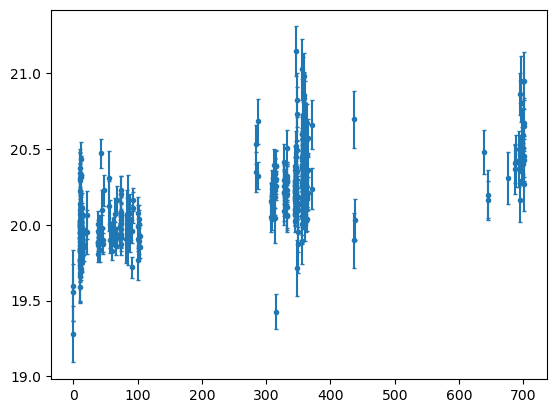

In [3]:
plt.errorbar(time-jnp.min(time), mag, yerr= mag_err, capsize = 1.5, fmt = '.')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(1./freq, score)
plt.xlabel('period [days]')
plt.ylabel('periodogram score')
plt.savefig('myid_'+str(myid)+'.png')
plt.close()